<a href="https://colab.research.google.com/github/ASEM000/PyTreeClass/blob/main/assets/benchmark_flatten_unflatten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install equinox
!pip install pytreeclass
!pip install flax
!pip install simple_pytree

### Benchmark `flatten`/`unflatten`


### Count: 10

treeclass
10.4 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

flax
20.7 µs ± 4.13 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

equinox
16.7 µs ± 4.43 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

simple-pytree
10.7 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Count: 100

treeclass
40.4 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

flax
214 µs ± 7.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

equinox
113 µs ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

simple-pytree
33.1 µs ± 978 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Count: 1000

treeclass
353 µs ± 7.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

flax
12.2 ms ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

equinox
957 µs ± 297 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

simple-pytree
271 µs ± 7.33 µs per 

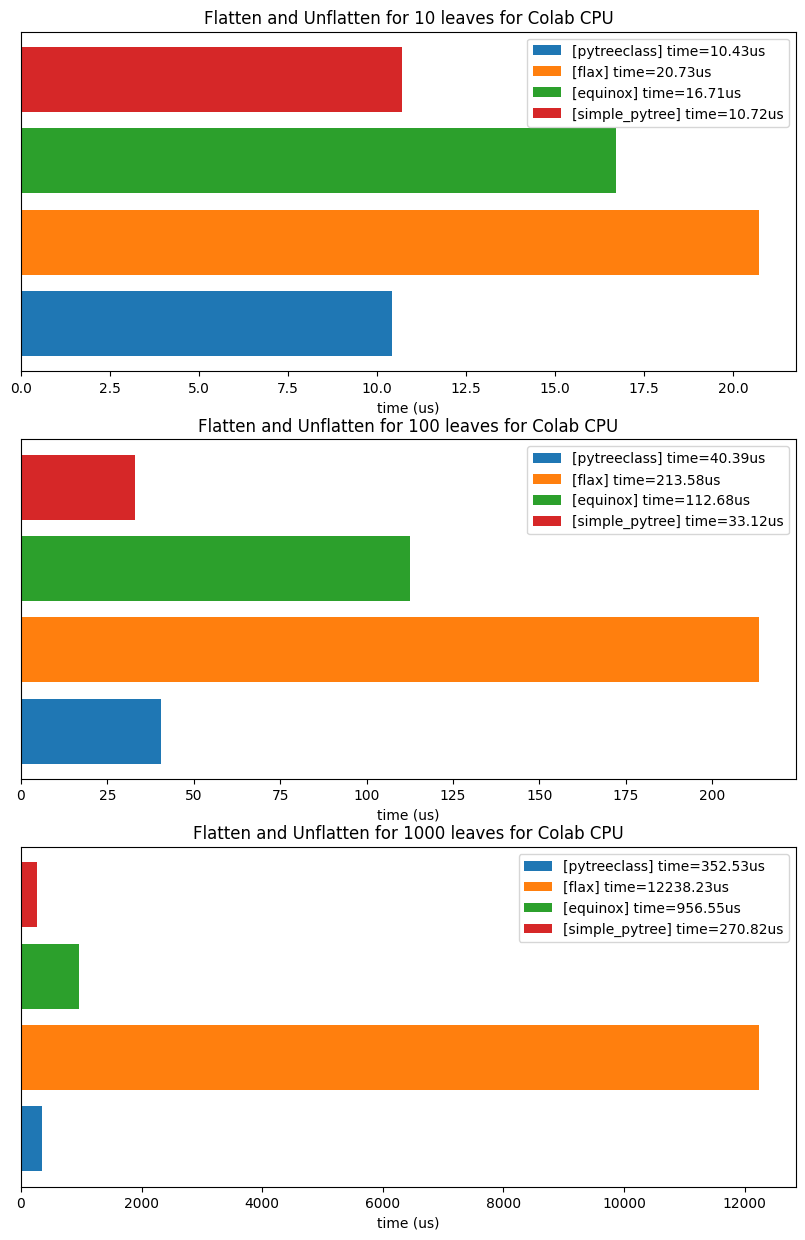

In [3]:
import string 
import random
import dataclasses as dc
import equinox as eqx
import flax 
import pytreeclass as pytc
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import simple_pytree as spt

def tree_copy(tree):
    leaves,treedef = jtu.tree_flatten(tree)
    return treedef.unflatten(leaves)

def random_string(length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))


def benchmark_flatten_unflatten(count:list[int]):
    t_pytc, t_flax, t_eqx, t_spt = {}, {}, {}, {}
    
    for c in count:
        print(f"\n### Count: {c}\n")
        names = [f"leaf_{_}" for _ in range(c)]
        values = [_ for _ in range(c)]

        dcls  = dc.make_dataclass("dcls", list(zip(names, [float]*c)))
        treeclass_model = type("treeclass", (pytc.TreeClass, dcls), dict(zip(names, values)))(*values)
        print(f"treeclass")
        t_pytc[c] = %timeit -o tree_copy(treeclass_model)
        print()

        dcls = dc.make_dataclass("dcls", list(zip(names, [float]*c)), frozen=True)
        flax_model = type("flax", (flax.struct.PyTreeNode, dcls), dict(zip(names, values)))(*values)
        print(f"flax")
        t_flax[c] = %timeit -o tree_copy(flax_model)
        print()

        dcls = dc.make_dataclass("dcls", list(zip(names, [float]*c)))
        eqx_model = type("eqx", (eqx.Module, dcls), dict(zip(names, values)))(*values)
        print(f"equinox")
        t_eqx[c] = %timeit -o tree_copy(eqx_model)
        print()

        dcls = dc.make_dataclass("dcls", list(zip(names, [float]*c)))
        spt_model = type("simple_pytree", (spt.Pytree, dcls), dict(zip(names, values)))(*values)
        print(f"simple-pytree")
        t_spt[c] = %timeit -o tree_copy(spt_model)
        print()
        
    return t_pytc, t_flax, t_eqx, t_spt

counts = [10,100,1000]
t_pytc, t_flax, t_eqx, t_spt = benchmark_flatten_unflatten(counts)

plt.figure(figsize=(10,15))
for i, count in enumerate(counts):
    plt.subplot(3,1,i+1)
    # plot bar plot for pytreeclass
    t = t_pytc[count].average*1e6
    plt.barh("pytreeclass",t, label=f"[pytreeclass] time={t:.2f}us")
    # plot bar plot for flax
    t = t_flax[count].average*1e6
    plt.barh("flax", t, label=f"[flax] time={t:.2f}us")
    # plot bar plot for equinox
    t = t_eqx[count].average*1e6
    plt.barh("equinox", t, label=f"[equinox] time={t:.2f}us")
    # plot bar plot for simple_pytree
    t = t_spt[count].average*1e6
    plt.barh("simple-pytree", t, label=f"[simple_pytree] time={t:.2f}us")
    

    plt.title(f"Flatten and Unflatten for {count} leaves for Colab CPU")
    plt.xlabel("time (us)")
    plt.yticks([]) 
    plt.legend()